# Global Greening

## Installing & Importing Libraries

this notebook version is setup so we can run the model based on data locally on VM machine in GCP 

In [3]:
import pickle
import numpy as np
import pandas as pd
import math
import time
from PIL import Image
from patchify import patchify
# import albumentations as A
from IPython.display import SVG
#import graphviz
import matplotlib.pyplot as plt
%matplotlib inline
import os, re, sys, random, shutil #, cv2
from google.cloud import storage

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import model_to_dot, plot_model, image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, LearningRateScheduler
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, ZeroPadding2D, Dropout

from sklearn.preprocessing import MinMaxScaler

/Users/Alenka/.pyenv/versions/3.10.6/envs/GlobalGreening/lib/python3.10/site-packages/tensorflow_io-0.32.0-py3.10-macosx-13.3-arm64.egg/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/Users/Alenka/.pyenv/versions/3.10.6/envs/GlobalGreening/lib/python3.10/site-packages/tensorflow_io-0.32.0-py3.10-macosx-13.3-arm64.egg/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["[Errno 2] The file to load file system plugin from does not exist.: '/Users/Alenka/.pyenv/versions/3.10.6/envs/GlobalGreening/lib/python3.10/site-packages/tensorflow_io-0.32.0-py3.10-macosx-13.3-arm64.egg/tensorflow_io/python/ops/libtensorflow_io_plugins.so'"]
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/Users/Alenka/.pyenv/versions/3.10.6/envs/GlobalGreening/lib/python3.10/site-packages/tensorflow_io-0.32.0-py3.10-macosx-13.3-arm64.egg/tensorflow_io/python/ops/__init__

## Model information

[key link](https://github.com/kunnalparihar/Satellite-Image-Segmentation)

## Prepara Data Augmentation - ignore, not used

**Augmentation using Albumentations Library**

[Albumentations](https://albumentations.ai/) is a Python library for fast and flexible image augmentations. Albumentations efficiently implements a rich variety of image transform operations that are optimized for performance, and does so while providing a concise, yet powerful image augmentation interface for different computer vision tasks, including object classification, segmentation, and detection.

Data augmentation is done by the following techniques:

1. Random Cropping - left out since we will have same size pictures
2. Horizontal Flipping
3. Vertical Flipping
4. Rotation
5. Random Brightness & Contrast
6. Contrast Limited Adaptive Histogram Equalization (CLAHE)
7. Grid Distortion
8. Optical Distortion

In [ ]:
# # function to augment
# def augment(): #width, height
#     transform = A.Compose([
# #        A.RandomCrop(width=width, height=height, p=1.0),
#         A.HorizontalFlip(p=1.0),
#         A.VerticalFlip(p=1.0),
#         A.Rotate(limit=[60, 300], p=1.0, interpolation=cv2.INTER_NEAREST),
#         A.RandomBrightnessContrast(brightness_limit=[-0.2, 0.3], contrast_limit=0.2, p=1.0),
#         A.OneOf([
#             A.CLAHE (clip_limit=1.5, tile_grid_size=(8, 8), p=0.5),
#             A.GridDistortion(p=0.5),
#             A.OpticalDistortion(distort_limit=1, shift_limit=0.5, interpolation=cv2.INTER_NEAREST, p=0.5),
#         ], p=1.0),
#     ], p=1.0)
    
#     return transform

In [ ]:
# # visualize the augmentations

# def visualize(image, mask, original_image=None, original_mask=None):
#     fontsize = 16

#     if original_image is None and original_mask is None:
#         f, ax = plt.subplots(2, 1, figsize=(10, 10)) 

#         ax[0].imshow(image)
#         ax[1].imshow(mask)
#     else:
#         f, ax = plt.subplots(2, 2, figsize=(16, 12))  

#         ax[0, 0].imshow(original_image)
#         ax[0, 0].set_title('Original Image', fontsize=fontsize)

#         ax[1, 0].imshow(original_mask)
#         ax[1, 0].set_title('Original Mask', fontsize=fontsize)

#         ax[0, 1].imshow(image)
#         ax[0, 1].set_title('Transformed Image', fontsize=fontsize)

#         ax[1, 1].imshow(mask)
#         ax[1, 1].set_title('Transformed Mask', fontsize=fontsize)
        
#     plt.savefig('sample_augmented_image.png', facecolor= 'w', transparent= False, bbox_inches= 'tight', dpi= 100)

## Key Params

Please make sure to create local folder structure in following way:

     |
     |---- raw_data
     |    |---- zoomed_photos
     |    |---- ESA_worldcover
     |
     |---- training_outputs
     |    |---- metrics
     |    |---- models
     |    |---- params

there will a folder for predictions as well, but will sort it out later

In [4]:
# parameters
DATA_SIZE=1500
LOAD_CHUNK_SIZE=500
LAND_USE_ARRAY_SIZE=250
TRIAL_SIZE=200     # after running it once change to a larger number (up to 15000)
DATA_RUN = 'local' #  select from these options:'gcp' local_VM' , 'local' 

# on Tim's GCP loading data from Bucket
BUCKET_NAME = "GlobalGreening"
images_dir = "zoomed_photos"
masks_dir = "ESA_worldcover"
training_output_dir = "training_outputs"

# on Tim's GCP loading data locally from VM  - change to what is has to be 
VM_dataset_folder = "jupyter/raw_data"  # tim you need to add it here
VM_images_dir = "zoomed_photos/zoomed_photos"
VM_masks_dir = 'ESA_worldcover'
VM_output_folder = "jupyter/training_outputs" # tim you need to add it here

### for local use - Alenka's computer
local_dataset_folder = "/Users/Alenka/code/Alastair908/GlobalGreening/raw_data"
local_images_dir = "images_trial_run"
local_masks_dir = "masks_trial_run"
local_output_folder = "/Users/Alenka/code/Alastair908/GlobalGreening/training_outputs"

In [40]:
# Define where to store model outputs

timestamp = time.strftime("%Y%m%d-%H%M%S")

if DATA_RUN == 'gcp':
    pass # not completed yet

elif DATA_RUN == 'local_VM':
    model_path = os.path.join(VM_output_folder, "models", f"{timestamp}_InceptionResNetV2-UNet.h5")
    results_path = os.path.join(VM_output_folder, "metrics", f"{timestamp}_model_training.csv")
    model_metrics_plot_path = os.path.join(VM_output_folder, "metrics", f"{timestamp}_model_metrics_plot.png")
    predictions_dir = os.path.join(VM_output_folder, f"{timestamp}_predictions")
    
elif DATA_RUN == 'local':
    model_path = os.path.join(local_output_folder, "models", f"{timestamp}_InceptionResNetV2-UNet.h5")
    results_path = os.path.join(local_output_folder, "metrics", f"{timestamp}_model_training.csv")
    model_metrics_plot_path = os.path.join(local_output_folder, "metrics", f"{timestamp}_model_metrics_plot.png")
    predictions_dir = os.path.join(local_output_folder,  f"{timestamp}_predictions")
    
print("--------")
print(f' model path is {model_path}')
print("--------")
print(f' results path is {results_path}')
print("--------")
print(f' model metrics path is {model_metrics_plot_path}')
print("--------")
print(f'predictions folder is {predictions_dir}')

--------
 model path is /Users/Alenka/code/Alastair908/GlobalGreening/training_outputs/models/20230611-083158_InceptionResNetV2-UNet.h5
--------
 results path is /Users/Alenka/code/Alastair908/GlobalGreening/training_outputs/metrics/20230611-083158_model_training.csv
--------
 model metrics path is /Users/Alenka/code/Alastair908/GlobalGreening/training_outputs/metrics/20230611-083158_model_metrics_plot.png
--------
predictions folder is /Users/Alenka/code/Alastair908/GlobalGreening/training_outputs/20230611-083158_predictions


In [6]:
!pwd

/Users/Alenka/code/Alastair908/GlobalGreening/notebooks


In [41]:
# ***** NOT USED YET (folder to save predictions) ****** 

# # please make predictions directory based on what was printed out
# # check if any folders need to be created and adjust the below command 
# (see pwd path above)

# !mkdir -p ../training_outputs/20230610-132230_predictions

## Loading the Data

### Functions to load data locally or locally from VM

In [7]:
# functions used to load images

def get_image_geo_locations(dataset_root_folder, images_dir):
    # generating file names from the directory
    
    images_directory = f'{dataset_root_folder}/{images_dir}'
    print(f'loading file names from {images_directory}')
    image_files = np.sort(os.listdir(images_directory))
    file_names = np.char.rstrip(image_files, '.png')
    file_names = np.char.split(file_names, '_') 

    print(f'sample images file names {image_files[:3]} and amount of images in the directory {len(image_files)}')
    print(f'sample split file names {file_names[:3]}, and check that same lenght of lists {len(file_names)}')

    # creating df with information about longitude, latitude (can also be used to load the images)
    image_geo_locations = np.zeros((len(file_names),2))
    image_geo_locations = pd.DataFrame(image_geo_locations, columns=['latitude', 'longitude'])

    for image_type in ['latitude', 'longitude']:
        for i in range(len(file_names)):
            file = file_names[i]
            
            if image_type == 'latitude':
                text = file[0]
                image_number = ''.join(num for num in text if num.isdigit())
                latitude = file[1].strip('-') 
    #            print(f'latitude is {latitude}')
                image_geo_locations.at[int(image_number),'latitude'] = latitude
                                    
            elif image_type == 'longitude':
                text = file[0]
                image_number = ''.join(num for num in text if num.isdigit())
                longitude = file[2] 
    #            print(f'longitude is {longitude}')
                image_geo_locations.at[int(image_number),'longitude'] = longitude                     
    return image_geo_locations

def load_images(dataset_root_folder, images_dir, load_range_images):
    
    image_geo_locations = get_image_geo_locations(dataset_root_folder, images_dir)

    # loading images into the list (new code so the files are loaded in correct order (by index))
    images_dataset = []

    for i in range(load_range_images):
        image_file =f'image{i}_-{image_geo_locations.iat[i,0]}_{image_geo_locations.iat[i,1]}.png'
        path_image = f'{dataset_root_folder}/{images_dir}/{image_file}'
        print(f'loading the image from these file {path_image}')
        
        image = Image.open(path_image)
        type(image)
        if np.asarray(image).shape[2] >3: 
            image = image.convert('RGB')
        
        image = np.asarray(image)
        images_dataset.append(image)
        print(f'appended image of size {image.shape}')
    
    images_dataset = np.array(images_dataset)
    
    return images_dataset


def load_masks(dataset_root_folder, masks_dir, load_range_masks, land_use_array_size):

    for i in range(load_range_masks):
        mask_file = f'land_use_data_from_{i*land_use_array_size}_to_{(i+1)*land_use_array_size-1}.npy'
        path_mask = f'{dataset_root_folder}/{masks_dir}/{mask_file}'
        print(f'loading the masks from these file {path_mask}')
        
        masks_dataset_dir = f'masks_dataset{i+1}'
        if i == 0:
            masks_dataset = np.load(path_mask)
            print(f'loading array {i+1} into mask dataset with shape {masks_dataset.shape}')
    
        else:
            array_to_append = np.load(path_mask)
            masks_dataset = np.vstack((masks_dataset, array_to_append))
            print(f'appending to masks_dataset an array {i+1} with shape {array_to_append.shape}')
    
    return masks_dataset

### Functions to load data from bucket (GCP option) 

In [ ]:
# # some options to open files from Bucket/blobs directly - 
# # not used as I am not sure it works with GCP

# def open_image_from_bucket(bucket, blob_file_path):
#     storage_client = storage.Client()
#     file_byte_string = storage_client.get_object(Bucket=bucket, Key=key)['Body'].read()
#     return Image.open(BytesIO(file_byte_string)

In [9]:
# list files in blobs

def list_blobs(bucket_name):
    """Lists all the blobs in the bucket."""
    storage_client = storage.Client()
    
    # Note: Client.list_blobs requires at least package version 1.17.0.
    blobs = storage_client.list_blobs(bucket_name)
    
    image_file_list = []
    mask_file_list = []
    
    for blob in blobs:
        file_name = blob.split('/')[1]
        
        if file_name.endswith('.png'):
            image_file_list.append(file_name)
        if file_name.endswith('.npy'):
            mask_file_list.append(file_name)
        
    image_file_list = np.sort(image_file_list)
    mask_file_list = np.sort(mask_file_list)

    return image_file_list, mask_file_list


# functions used to load images from buckets, and from blobs

def bucket_get_image_geo_locations(bucket_name):
    # generating file names from the directory
    print(f'loading image and mask file names from {bucket_name}')
    image_file_list, mask_file_list = list_blobs(bucket_name)

    file_names = np.char.rstrip(image_file_list, '.png')
    file_names = np.char.split(file_names, '_') 

    print(f'sample images file names {image_file_list[:3]} and amount of images in the directory {len(image_file_list)}')
    print(f'sample split file names {file_names[:3]}, and check that same lenght of lists {len(file_names)}')

    # creating df with information about longitude, latitude (can also be used to load the images)
    image_geo_locations = np.zeros((len(file_names),2))
    image_geo_locations = pd.DataFrame(image_geo_locations, columns=['latitude', 'longitude'])

    for image_type in ['latitude', 'longitude']:
        for i in range(len(file_names)):
            file = file_names[i]
            
            if image_type == 'latitude':
                text = file[0]
                image_number = ''.join(num for num in text if num.isdigit())
                latitude = file[1].strip('-') 
    #            print(f'latitude is {latitude}')
                image_geo_locations.at[int(image_number),'latitude'] = latitude
                                    
            elif image_type == 'longitude':
                text = file[0]
                image_number = ''.join(num for num in text if num.isdigit())
                longitude = file[2] 
    #            print(f'longitude is {longitude}')
                image_geo_locations.at[int(image_number),'longitude'] = longitude                     
    return image_geo_locations

def bucket_load_images(bucket_name, images_dir, load_range_images):
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    
    image_geo_locations = get_image_geo_locations(bucket_name)
    image_file_list, mask_file_list = list_blobs(bucket_name)
    
    # loading images into the list (new code so the files are loaded in correct order (by index))
    
    images_dataset = []

    for i in range(load_range_images):
        image_file =f'image{i}_-{image_geo_locations.iat[i,0]}_{image_geo_locations.iat[i,1]}.png'
        path_image = f'{images_dir}/{image_file}'
        print(f'loading the image from these file {path_image}')
        
        blob = bucket.blob(path_image)
        blob.download_to_file(file_obj)
        image = Image.open(file_obj)
        
        if np.asarray(image).shape[2] >3: 
            image = image.convert('RGB')
        
        image = np.asarray(image)
        images_dataset.append(image)
        print(f'appended image of size {image.shape}')
    
    images_dataset = np.array(images_dataset)
    
    return images_dataset


def bucket_load_masks(bucket_name, masks_dir, load_range_masks, land_use_array_size):
    
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name) 

    for i in range(load_range_masks):
        mask_file = f'land_use_data_from_{i*land_use_array_size}_to_{(i+1)*land_use_array_size-1}.npy'
        path_mask = f'{masks_dir}/{mask_file}'
        print(f'loading the masks from these file {path_mask}')

        blob = bucket.blob(path_mask)
        blob.download_to_file(file_obj)
        
        masks_dataset_dir = f'masks_dataset{i+1}'
        
        if i == 0:
            masks_dataset = np.load(file_obj)
            print(f'loading array {i+1} into mask dataset with shape {masks_dataset.shape}')
    
        else:
            array_to_append = np.load(file_obj)
            masks_dataset = np.vstack((masks_dataset, array_to_append))
            print(f'appending to masks_dataset an array {i+1} with shape {array_to_append.shape}')
    
    return masks_dataset

### Start loading data

In [10]:
# calculate some variables that are used for loading

# flexible in case we will need LOAD_CHUNK_SIZE later when we 
# e.g. load 500 images for model, and then next 500 ... 
load_range_images = min(TRIAL_SIZE, LOAD_CHUNK_SIZE) 
print(f'load range for images is {load_range_images}')

# load_range_masks is number of arrays to load (each one 250 masks) 
load_range_masks = math.ceil(TRIAL_SIZE/LAND_USE_ARRAY_SIZE) 
print(f'load range for masks is {load_range_masks}')

load range for images is 200
load range for masks is 1


In [11]:
if DATA_RUN == 'gcp':
    images_dataset = load_images(BUCKET_NAME, 
                                 images_dir, 
                                 TRIAL_SIZE)
    masks_dataset = load_images(BUCKET_NAME, 
                                masks_dir, 
                                TRIAL_SIZE, 
                                LAND_USE_ARRAY_SIZE)

elif DATA_RUN == 'local_VM':
    images_dataset = load_images(VM_dataset_folder, 
                                 VM_images_dir, 
                                 load_range_images)
    masks_dataset = load_images(VM_dataset_folder, 
                                VM_masks_dir, 
                                load_range_masks,
                                LAND_USE_ARRAY_SIZE)

elif DATA_RUN == 'local':
    images_dataset = load_images(local_dataset_folder, 
                                 local_images_dir, 
                                 load_range_images)
    masks_dataset = load_masks(local_dataset_folder, 
                               local_masks_dir, 
                               load_range_masks, 
                               LAND_USE_ARRAY_SIZE)

loading file names from /Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run
sample images file names ['image0_-109.0_37.0.png' 'image100_-108.96_37.26.png'
 'image101_-108.96_37.3.png'] and amount of images in the directory 500
sample split file names [list(['image0', '-109.0', '37.0']) list(['image100', '-108.96', '37.26'])
 list(['image101', '-108.96', '37.3'])], and check that same lenght of lists 500
loading the image from these file /Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image0_-109.0_37.0.png
appended image of size (512, 512, 3)
loading the image from these file /Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image1_-109.0_37.04.png
appended image of size (512, 512, 3)
loading the image from these file /Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image2_-109.0_37.09.png
appended image of size (512, 512, 3)
loading the image from these file /Users/Alenka/code/Alastair908/GlobalG

appended image of size (512, 512, 3)
loading the image from these file /Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image59_-109.0_39.52.png
appended image of size (512, 512, 3)
loading the image from these file /Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image60_-109.0_39.56.png
appended image of size (512, 512, 3)
loading the image from these file /Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image61_-109.0_39.6.png
appended image of size (512, 512, 3)
loading the image from these file /Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image62_-109.0_39.65.png
appended image of size (512, 512, 3)
loading the image from these file /Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image63_-109.0_39.69.png
appended image of size (512, 512, 3)
loading the image from these file /Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image64_-109.0_39.

appended image of size (512, 512, 3)
loading the image from these file /Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image121_-108.96_38.15.png
appended image of size (512, 512, 3)
loading the image from these file /Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image122_-108.96_38.2.png
appended image of size (512, 512, 3)
loading the image from these file /Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image123_-108.96_38.24.png
appended image of size (512, 512, 3)
loading the image from these file /Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image124_-108.96_38.28.png
appended image of size (512, 512, 3)
loading the image from these file /Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image125_-108.96_38.32.png
appended image of size (512, 512, 3)
loading the image from these file /Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image126

appended image of size (512, 512, 3)
loading the image from these file /Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image184_-108.96_40.84.png
appended image of size (512, 512, 3)
loading the image from these file /Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image185_-108.96_40.89.png
appended image of size (512, 512, 3)
loading the image from these file /Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image186_-108.96_40.93.png
appended image of size (512, 512, 3)
loading the image from these file /Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image187_-108.96_40.97.png
appended image of size (512, 512, 3)
loading the image from these file /Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image188_-108.91_37.0.png
appended image of size (512, 512, 3)
loading the image from these file /Users/Alenka/code/Alastair908/GlobalGreening/raw_data/images_trial_run/image189

### Checking the size and type of loaded images, masks 

Run all these cells just to see nothing weird happened while loading data

In [12]:
len(images_dataset), images_dataset[0].shape, type(images_dataset[0]), type(images_dataset)

(200, (512, 512, 3), numpy.ndarray, numpy.ndarray)

In [13]:
len(masks_dataset), masks_dataset[0].shape, type(masks_dataset[0]), type(masks_dataset)

(250, (512, 512, 3), numpy.ndarray, numpy.ndarray)

In [14]:
image_sizes = []

for i in range(len(images_dataset)):
    image_sizes.append(images_dataset[i].shape)

min(image_sizes), max(image_sizes)
min(image_sizes), max(image_sizes)

((512, 512, 3), (512, 512, 3))

In [16]:
mask_sizes = []

for i in range(len(masks_dataset)):
    mask_sizes.append(masks_dataset[i].shape)

min(mask_sizes), max(mask_sizes)

((512, 512, 3), (512, 512, 3))

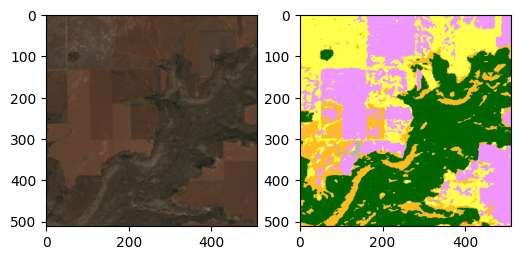

In [15]:
# check random image + mask combinations

i = random.randint(0, TRIAL_SIZE)
f, ax = plt.subplots(1, 2, figsize=(6, 6)) 
ax[0].imshow(images_dataset[i])
ax[1].imshow(masks_dataset[i])

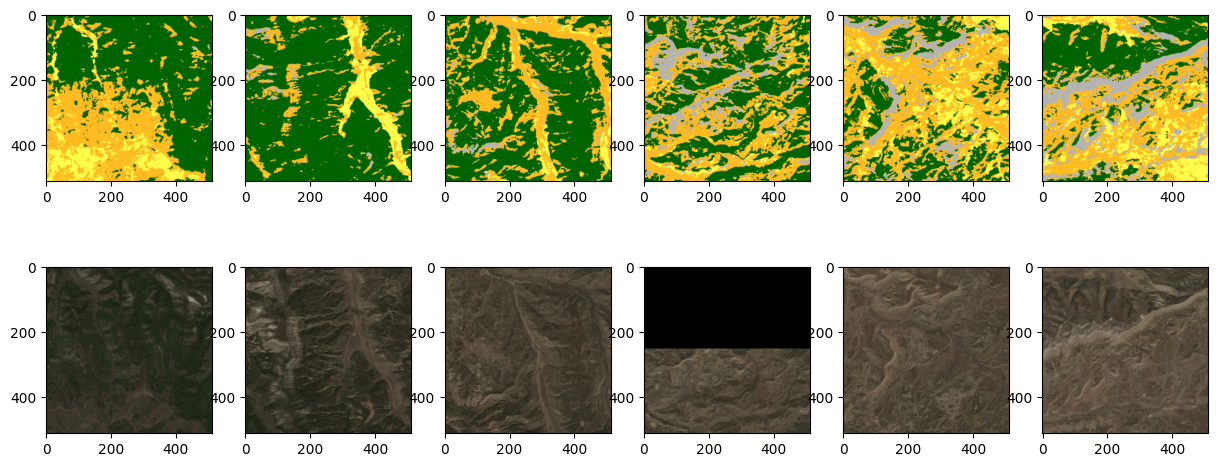

In [18]:
# random check of 6 masks and respective images

i = random.randint(0, TRIAL_SIZE-5)

f, ax = plt.subplots(2, 6, figsize=(15, 6)) 

ax[0,0].imshow(masks_dataset[i])
ax[0,1].imshow(masks_dataset[i+1])
ax[0,2].imshow(masks_dataset[i+2])
ax[0,3].imshow(masks_dataset[i+3])
ax[0,4].imshow(masks_dataset[i+4])
ax[0,5].imshow(masks_dataset[i+5])


ax[1,0].imshow(images_dataset[i])
ax[1,1].imshow(images_dataset[i+1])
ax[1,2].imshow(images_dataset[i+2])
ax[1,3].imshow(images_dataset[i+3])
ax[1,4].imshow(images_dataset[i+4])
ax[1,5].imshow(images_dataset[i+5])

## Image masks

Value	Color	Description
- 10	#006400	Tree cover 
<p align="center"><div style="background-color: #006400; padding: 10px; "/></p>   
- 20	#ffbb22	Shrubland 
<p align="center"><div style="background-color: #ffbb22; padding: 10px; "/></p>   
- 30	#ffff4c	Grassland
<p align="center"><div style="background-color: #ffff4c; padding: 10px; "/></p>   
- 40	#f096ff	Cropland
<p align="center"><div style="background-color: #f096ff; padding: 10px; "/></p>  
- 50	#fa0000	Built-up
<p align="center"><div style="background-color: #fa0000; padding: 10px; "/></p>  
- 60	#b4b4b4	Bare / sparse vegetation
<p align="center"><div style="background-color: #b4b4b4; padding: 10px; "/></p>  
- 70	#f0f0f0	Snow and ice
<p align="center"><div style="background-color: #f0f0f0; padding: 10px; "/></p>  
- 80	#0064c8	Permanent water bodies
<p align="center"><div style="background-color: #0064c8; padding: 10px; "/></p>  
- 90	#0096a0	Herbaceous wetland
<p align="center"><div style="background-color: #0096a0; padding: 10px; "/></p>  
- 95	#00cf75	Mangroves
<p align="center"><div style="background-color: #00cf75; padding: 10px; "/></p>  
- 100	#fae6a0	Moss and lichen
<p align="center"><div style="background-color: #fae6a0; padding: 10px; "/></p>  

### Preparing labels

In [19]:
labels_dict = {"classes": [
{"title": "Tree cover", "r": 0 , "g": 0 , "b": 0 }, 
{"title": "Shrubland", "r": 0, "g": 0, "b": 0 }, 
{"title": "Grassland", "r": 0, "g": 0, "b": 0 }, 
{"title": "Cropland", "r": 0, "g": 0, "b": 0 }, 
{"title": "Built-up", "r": 0, "g": 0, "b": 0 }, 
{"title": "Bare, sparse vegetation", "r": 0, "g": 0, "b": 0 },
{"title": "Snow and ice", "r": 0, "g": 0, "b": 0 },
{"title": "Permanent water bodies", "r": 0, "g": 0, "b": 0 },
{"title": "Herbaceous wetland", "r": 0, "g": 0, "b": 0 },
{"title": "Mangroves", "r": 0, "g": 0, "b": 0 },
{"title": "Moss and lichen", "r": 0, "g": 0, "b": 0 }
]}


# loading correct rgb values from hex_color list based on ESA  
hex_colors_list = ['#006400', '#ffbb22', '#ffff4c', '#f096ff', '#fa0000',
                    '#b4b4b4', '#f0f0f0', '#0064c8', '#0096a0', '#00cf75', '#fae6a0']

In [20]:
# preparing label df with all information: classes, rgb values

def prepare_labels(labels_dict, hex_colors_list):

    labels_dict_df = pd.DataFrame(labels_dict['classes'])
    
    for i in range(len(hex_colors_list)):
        color = hex_colors_list[i].lstrip('#')
        r = int(color[0:2],16)
        g = int(color[2:4],16)
        b = int(color[4:6],16)
        labels_dict_df.at[i,'r'] = r
        labels_dict_df.at[i,'g'] = g
        labels_dict_df.at[i,'b'] = b
    
    return labels_dict_df

# preparing label codes (just rgb values in order of classes)

def prepare_label_codes(labels_dict, hex_colors_list):
    labels_dict_df = prepare_labels(labels_dict, hex_colors_list)
    
    label_codes = []
    r= np.asarray(labels_dict_df.r)
    g= np.asarray(labels_dict_df.g)
    b= np.asarray(labels_dict_df.b)

    for i in range(len(labels_dict_df)):
        label_codes.append(tuple([r[i], g[i], b[i]]))
    return label_codes

# preparing label names (just class names)

def prepare_label_names(labels_dict, hex_colors_list):
    labels_dict_df = prepare_labels(labels_dict, hex_colors_list)   
    label_names= list(labels_dict_df.title)
    return label_names

In [21]:
# preparing label codes (just rgb values in order of classes)

def prepare_label_codes(labels_dict, hex_colors_list):
    labels_dict_df = prepare_labels(labels_dict, hex_colors_list)
    
    label_codes = []
    r= np.asarray(labels_dict_df.r)
    g= np.asarray(labels_dict_df.g)
    b= np.asarray(labels_dict_df.b)

    for i in range(len(labels_dict_df)):
        label_codes.append(tuple([r[i], g[i], b[i]]))
    return label_codes

# preparing label names (just class names)

def prepare_label_names(labels_dict, hex_colors_list):
    labels_dict_df = prepare_labels(labels_dict, hex_colors_list)   
    label_names= list(labels_dict_df.title)
    return label_names

In [22]:
label_codes = prepare_label_codes(labels_dict, hex_colors_list)
label_names = prepare_label_names(labels_dict, hex_colors_list)

code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

name2id = {v:k for k,v in enumerate(label_names)}
id2name = {k:v for k,v in enumerate(label_names)}

In [23]:
print(f'label codes are {label_codes}')
print('----')
print(f'label names are {label_names}')

label codes are [(0, 100, 0), (255, 187, 34), (255, 255, 76), (240, 150, 255), (250, 0, 0), (180, 180, 180), (240, 240, 240), (0, 100, 200), (0, 150, 160), (0, 207, 117), (250, 230, 160)]
----
label names are ['Tree cover', 'Shrubland', 'Grassland', 'Cropland', 'Built-up', 'Bare, sparse vegetation', 'Snow and ice', 'Permanent water bodies', 'Herbaceous wetland', 'Mangroves', 'Moss and lichen']


### Functions to One-hot Encode RGB Labels/Masks and Decoding Encoded Predictions

In [24]:
# one-hot encoder 
def rgb_to_onehot(rgb_mask_image, colormap = id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 512 x 512 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    rgb_mask_to_encode = rgb_mask_image*255
#    print(f'shape of mask to encode is {rgb_mask_to_encode.shape}')
    # shape prepared for image size and channels = num of classes (instead of 3 RGB colors)
    shape = rgb_mask_to_encode.shape[:2]+(num_classes,)
#    print(f'prepared shape for encoded mask is {shape}')
    
    # encoded_image prepare array with right shaoe 
    encoded_mask = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        # image.reshape flattens and keeps 3 channels, then checks which pixels same as color in colormap
        # then change back to image size for each of 6 channels (based on colormap)
        encoded_mask[:,:,i] = np.all(rgb_mask_to_encode.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    
#    print(f'encoded mask shape is {encoded_mask.shape}')
    return encoded_mask

def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

def preprocess_images (images):
    images = images/255.
    return images

def encoding_masks(masks_dataset, colormap = id2code):
    encoded_masks = []
#    print(f'range is {len(masks_dataset)}')
    
    for i in range(len(masks_dataset)): 
        mask = masks_dataset[i]
        encoded_mask = rgb_to_onehot(mask, colormap)
        encoded_masks.append(encoded_mask)
    
    encoded_masks = np.array(encoded_masks) 
    return encoded_masks

mask shape is RGB image (512, 512, 3)
encoded mask is 6 channel array (512, 512, 11)
decoded mask is again RGB image (512, 512, 3)


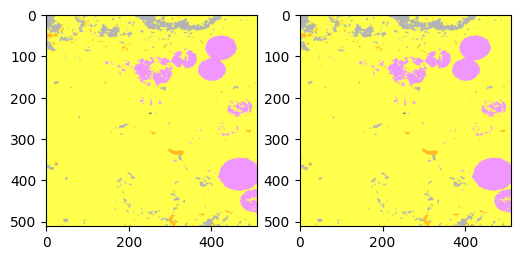

In [26]:
# checking that it works
mask = masks_dataset[5]
print(f'mask shape is RGB image {mask.shape}')
encoded_mask = rgb_to_onehot(mask, colormap = id2code)
decoded_mask = onehot_to_rgb(encoded_mask, colormap = id2code)

print(f'encoded mask is 6 channel array {encoded_mask.shape}')
print(f'decoded mask is again RGB image {decoded_mask.shape}')

f, ax = plt.subplots(1, 2, figsize=(6, 6)) 
ax[0].imshow(mask)
ax[1].imshow(decoded_mask)

## Model

### Loading X and y, split train, test

In [27]:
len(images_dataset), len(masks_dataset)

(200, 250)

In [28]:
len(images_dataset[0:TRIAL_SIZE]), len(masks_dataset[0:TRIAL_SIZE])

(200, 200)

In [29]:
# Preparing X(images) and y(labels) 
y = encoding_masks(masks_dataset[0:TRIAL_SIZE])
X = preprocess_images (images_dataset[0:TRIAL_SIZE])

In [30]:
# Finally we shuffle:
p = np.random.permutation(len(X))
X, y = X[p], y[p]

# split is for train/val data and for test data
split = int(len(X) /6.) 
X_test, X_train = X[:split], X[split:]
y_test, y_train = y[:split], y[split:] 

In [31]:
len(X_test), len(X_train), len(y_test), len(y_train)

(33, 167, 33, 167)

In [32]:
X_test.shape, X_train.shape, y_test.shape, y_train.shape

((33, 512, 512, 3),
 (167, 512, 512, 3),
 (33, 512, 512, 11),
 (167, 512, 512, 11))

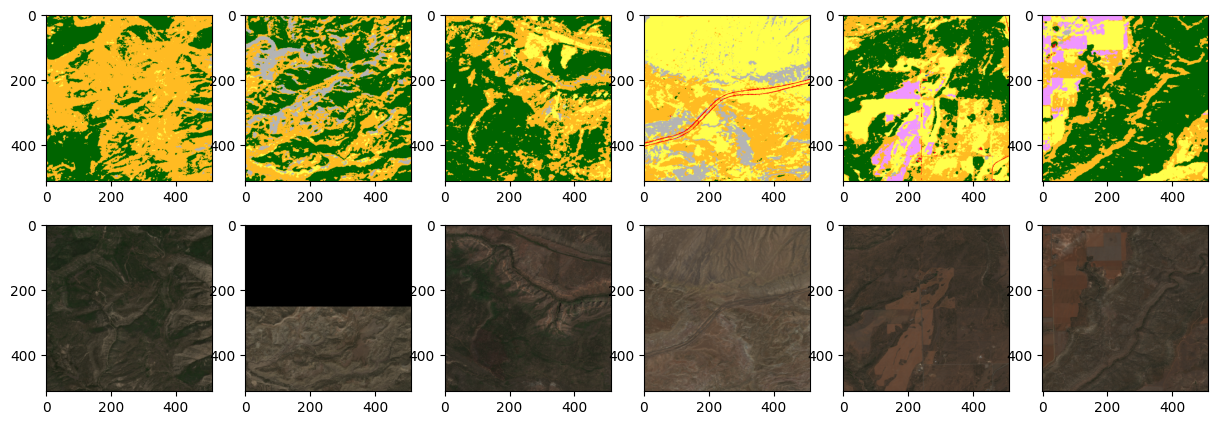

In [34]:
# random check of 6 masks and respective images

i = random.randint(0, len(y_train)-5)

f, ax = plt.subplots(2, 6, figsize=(15, 5)) 

ax[0,0].imshow(onehot_to_rgb(y_train[i]))
ax[0,1].imshow(onehot_to_rgb(y_train[i+1]))
ax[0,2].imshow(onehot_to_rgb(y_train[i+2]))
ax[0,3].imshow(onehot_to_rgb(y_train[i+3]))
ax[0,4].imshow(onehot_to_rgb(y_train[i+4]))
ax[0,5].imshow(onehot_to_rgb(y_train[i+5]))


ax[1,0].imshow(X_train[i])
ax[1,1].imshow(X_train[i+1])
ax[1,2].imshow(X_train[i+2])
ax[1,3].imshow(X_train[i+3])
ax[1,4].imshow(X_train[i+4])
ax[1,5].imshow(X_train[i+5])

### Setting up InceptionResNetV2 UNet

In [35]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_inception_resnetv2_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained InceptionResNetV2 Model """
    encoder = InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = encoder.get_layer("input_1").output           ## (512 x 512)

    s2 = encoder.get_layer("activation").output        ## (255 x 255)
    s2 = ZeroPadding2D(( (1, 0), (1, 0) ))(s2)         ## (256 x 256)

    s3 = encoder.get_layer("activation_3").output      ## (126 x 126)
    s3 = ZeroPadding2D((1, 1))(s3)                     ## (128 x 128)

    s4 = encoder.get_layer("activation_74").output      ## (61 x 61)
    s4 = ZeroPadding2D(( (2, 1),(2, 1) ))(s4)           ## (64 x 64)

    """ Bridge """
    b1 = encoder.get_layer("activation_161").output     ## (30 x 30)
    b1 = ZeroPadding2D((1, 1))(b1)                      ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)
    
    """ Output """
    dropout = Dropout(0.3)(d4)
    outputs = Conv2D(11, 1, padding="same", activation="softmax")(dropout)

    model = Model(inputs, outputs, name="InceptionResNetV2-UNet")
    return model

In [36]:
K.clear_session()

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

model = build_inception_resnetv2_unet(input_shape = (512, 512, 3))
model.compile(optimizer=Adam(lr = 0.0001), loss='categorical_crossentropy', metrics=[dice_coef, "accuracy"])
model.summary()

Model: "InceptionResNetV2-UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 255, 255, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 255, 255, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                            

                                                                                                  
 conv2d_10 (Conv2D)             (None, 61, 61, 96)   82944       ['activation_9[0][0]']           
                                                                                                  
 conv2d_11 (Conv2D)             (None, 61, 61, 64)   12288       ['average_pooling2d[0][0]']      
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 61, 61, 96)  288         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 61, 61, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
          

 conv2d_21 (Conv2D)             (None, 61, 61, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 batch_normalization_21 (BatchN  (None, 61, 61, 32)  96          ['conv2d_21[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_21 (Activation)     (None, 61, 61, 32)   0           ['batch_normalization_21[0][0]'] 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 61, 61, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 conv2d_22 (Conv2D)             (None, 61, 61, 48)   13824       ['activation_21[0][0]']          
          

 batch_normalization_26 (BatchN  (None, 61, 61, 32)  96          ['conv2d_26[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_29 (BatchN  (None, 61, 61, 64)  192         ['conv2d_29[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_24 (Activation)     (None, 61, 61, 32)   0           ['batch_normalization_24[0][0]'] 
                                                                                                  
 activation_26 (Activation)     (None, 61, 61, 32)   0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 activatio

 conv2d_37 (Conv2D)             (None, 61, 61, 32)   10240       ['block35_4_ac[0][0]']           
                                                                                                  
 conv2d_40 (Conv2D)             (None, 61, 61, 48)   13824       ['activation_39[0][0]']          
                                                                                                  
 batch_normalization_37 (BatchN  (None, 61, 61, 32)  96          ['conv2d_37[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_40 (BatchN  (None, 61, 61, 48)  144         ['conv2d_40[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 activation_44 (Activation)     (None, 61, 61, 32)   0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 activation_47 (Activation)     (None, 61, 61, 64)   0           ['batch_normalization_47[0][0]'] 
                                                                                                  
 block35_6_mixed (Concatenate)  (None, 61, 61, 128)  0           ['activation_42[0][0]',          
                                                                  'activation_44[0][0]',          
                                                                  'activation_47[0][0]']          
                                                                                                  
 block35_6_conv (Conv2D)        (None, 61, 61, 320)  41280       ['block35_6_mixed[0][0]']        
          

 batch_normalization_58 (BatchN  (None, 61, 61, 48)  144         ['conv2d_58[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 61, 61, 32)   0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 activation_58 (Activation)     (None, 61, 61, 48)   0           ['batch_normalization_58[0][0]'] 
                                                                                                  
 conv2d_54 (Conv2D)             (None, 61, 61, 32)   10240       ['block35_7_ac[0][0]']           
                                                                                                  
 conv2d_56 (Conv2D)             (None, 61, 61, 32)   9216        ['activation_55[0][0]']          
          

                                                                  'activation_65[0][0]']          
                                                                                                  
 block35_9_conv (Conv2D)        (None, 61, 61, 320)  41280       ['block35_9_mixed[0][0]']        
                                                                                                  
 custom_scale_layer_8 (CustomSc  (None, 61, 61, 320)  0          ['block35_8_ac[0][0]',           
 aleLayer)                                                        'block35_9_conv[0][0]']         
                                                                                                  
 block35_9_ac (Activation)      (None, 61, 61, 320)  0           ['custom_scale_layer_8[0][0]']   
                                                                                                  
 conv2d_69 (Conv2D)             (None, 61, 61, 32)   10240       ['block35_9_ac[0][0]']           
          

 batch_normalization_75 (BatchN  (None, 30, 30, 384)  1152       ['conv2d_75[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_72 (Activation)     (None, 30, 30, 384)  0           ['batch_normalization_72[0][0]'] 
                                                                                                  
 activation_75 (Activation)     (None, 30, 30, 384)  0           ['batch_normalization_75[0][0]'] 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 30, 30, 320)  0          ['block35_10_ac[0][0]']          
                                                                                                  
 mixed_6a (Concatenate)         (None, 30, 30, 1088  0           ['activation_72[0][0]',          
          

                                                                                                  
 block17_2_conv (Conv2D)        (None, 30, 30, 1088  418880      ['block17_2_mixed[0][0]']        
                                )                                                                 
                                                                                                  
 custom_scale_layer_11 (CustomS  (None, 30, 30, 1088  0          ['block17_1_ac[0][0]',           
 caleLayer)                     )                                 'block17_2_conv[0][0]']         
                                                                                                  
 block17_2_ac (Activation)      (None, 30, 30, 1088  0           ['custom_scale_layer_11[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_85

                                                                                                  
 custom_scale_layer_13 (CustomS  (None, 30, 30, 1088  0          ['block17_3_ac[0][0]',           
 caleLayer)                     )                                 'block17_4_conv[0][0]']         
                                                                                                  
 block17_4_ac (Activation)      (None, 30, 30, 1088  0           ['custom_scale_layer_13[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_93 (Conv2D)             (None, 30, 30, 128)  139264      ['block17_4_ac[0][0]']           
                                                                                                  
 batch_normalization_93 (BatchN  (None, 30, 30, 128)  384        ['conv2d_93[0][0]']              
 ormalizat

                                                                                                  
 block17_6_ac (Activation)      (None, 30, 30, 1088  0           ['custom_scale_layer_15[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_101 (Conv2D)            (None, 30, 30, 128)  139264      ['block17_6_ac[0][0]']           
                                                                                                  
 batch_normalization_101 (Batch  (None, 30, 30, 128)  384        ['conv2d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_101 (Activation)    (None, 30, 30, 128)  0           ['batch_normalization_101[0][0]']
          

                                                                                                  
 conv2d_109 (Conv2D)            (None, 30, 30, 128)  139264      ['block17_8_ac[0][0]']           
                                                                                                  
 batch_normalization_109 (Batch  (None, 30, 30, 128)  384        ['conv2d_109[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_109 (Activation)    (None, 30, 30, 128)  0           ['batch_normalization_109[0][0]']
                                                                                                  
 conv2d_110 (Conv2D)            (None, 30, 30, 160)  143360      ['activation_109[0][0]']         
                                                                                                  
 batch_nor

 batch_normalization_117 (Batch  (None, 30, 30, 128)  384        ['conv2d_117[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_117 (Activation)    (None, 30, 30, 128)  0           ['batch_normalization_117[0][0]']
                                                                                                  
 conv2d_118 (Conv2D)            (None, 30, 30, 160)  143360      ['activation_117[0][0]']         
                                                                                                  
 batch_normalization_118 (Batch  (None, 30, 30, 160)  480        ['conv2d_118[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 activation_125 (Activation)    (None, 30, 30, 128)  0           ['batch_normalization_125[0][0]']
                                                                                                  
 conv2d_126 (Conv2D)            (None, 30, 30, 160)  143360      ['activation_125[0][0]']         
                                                                                                  
 batch_normalization_126 (Batch  (None, 30, 30, 160)  480        ['conv2d_126[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_126 (Activation)    (None, 30, 30, 160)  0           ['batch_normalization_126[0][0]']
                                                                                                  
 conv2d_124 (Conv2D)            (None, 30, 30, 192)  208896      ['block17_12_ac[0][0]']          
          

                                                                                                  
 batch_normalization_134 (Batch  (None, 30, 30, 160)  480        ['conv2d_134[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_134 (Activation)    (None, 30, 30, 160)  0           ['batch_normalization_134[0][0]']
                                                                                                  
 conv2d_132 (Conv2D)            (None, 30, 30, 192)  208896      ['block17_14_ac[0][0]']          
                                                                                                  
 conv2d_135 (Conv2D)            (None, 30, 30, 192)  215040      ['activation_134[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 activation_142 (Activation)    (None, 30, 30, 160)  0           ['batch_normalization_142[0][0]']
                                                                                                  
 conv2d_140 (Conv2D)            (None, 30, 30, 192)  208896      ['block17_16_ac[0][0]']          
                                                                                                  
 conv2d_143 (Conv2D)            (None, 30, 30, 192)  215040      ['activation_142[0][0]']         
                                                                                                  
 batch_normalization_140 (Batch  (None, 30, 30, 192)  576        ['conv2d_140[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 conv2d_148 (Conv2D)            (None, 30, 30, 192)  208896      ['block17_18_ac[0][0]']          
                                                                                                  
 conv2d_151 (Conv2D)            (None, 30, 30, 192)  215040      ['activation_150[0][0]']         
                                                                                                  
 batch_normalization_148 (Batch  (None, 30, 30, 192)  576        ['conv2d_148[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_151 (Batch  (None, 30, 30, 192)  576        ['conv2d_151[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 conv2d_transpose (Conv2DTransp  (None, 64, 64, 512)  590336     ['zero_padding2d_3[0][0]']       
 ose)                                                                                             
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 64, 64, 256)  0          ['activation_74[0][0]']          
 D)                                                                                               
                                                                                                  
 concatenate (Concatenate)      (None, 64, 64, 768)  0           ['conv2d_transpose[0][0]',       
                                                                  'zero_padding2d_2[0][0]']       
                                                                                                  
 conv2d_203 (Conv2D)            (None, 64, 64, 512)  3539456     ['concatenate[0][0]']            
          

 conv2d_209 (Conv2D)            (None, 512, 512, 64  38656       ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_209 (Batch  (None, 512, 512, 64  256        ['conv2d_209[0][0]']             
 Normalization)                 )                                                                 
                                                                                                  
 activation_209 (Activation)    (None, 512, 512, 64  0           ['batch_normalization_209[0][0]']
                                )                                                                 
                                                                                                  
 conv2d_210 (Conv2D)            (None, 512, 512, 64  36928       ['activation_209[0][0]']         
          

### Modelling

In [37]:
# Define key parameters for training the model + savings results
PATIENCE = 4
BATCH_SIZE = 16 # smaller potentially better for model to perform, but means more epochs

steps_per_epoch = np.ceil(float(len(X_train)*0.8) / float(BATCH_SIZE))
print('steps_per_epoch: ', steps_per_epoch)

validation_steps = np.ceil(float(len(X_train)*0.2) / float(BATCH_SIZE))
print('validation_steps: ', validation_steps)

steps_per_epoch:  9.0
validation_steps:  3.0


In [38]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.0001, 60)

lr_scheduler = LearningRateScheduler(
    exponential_decay_fn,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath = model_path,
    save_best_only = True, 
#     save_weights_only = False,
    monitor = 'val_loss', 
    mode = 'auto', 
    verbose = 1
)

earlystop = EarlyStopping(
    monitor = 'val_loss', 
    min_delta = 0.001, 
    patience = PATIENCE, 
    mode = 'auto', 
    verbose = 1,
    restore_best_weights = True
)

csvlogger = CSVLogger(
    filename = results_path,
    separator = ",",
    append = False
)

callbacks = [checkpoint, earlystop, csvlogger, lr_scheduler]

In [ ]:
history = model.fit(
    X_train, 
    y_train,
    batch_size=BATCH_SIZE,
    validation_split = 0.2, 
    epochs = 50,
    callbacks=callbacks, 
    verbose=1
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/50


2023-06-11 08:33:52.372107: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


9/9 [==============================] - ETA: 0s - loss: 2.3905 - dice_coef: 0.1071 - accuracy: 0.1490 
Epoch 1: val_loss improved from inf to 2.40087, saving model to /Users/Alenka/code/Alastair908/GlobalGreening/training_outputs/models/20230611-082522_InceptionResNetV2-UNet.h5
9/9 [==============================] - 433s 47s/step - loss: 2.3905 - dice_coef: 0.1071 - accuracy: 0.1490 - val_loss: 2.4009 - val_dice_coef: 0.0910 - val_accuracy: 0.0838 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.623506263980886e-05.
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 2.0537 - dice_coef: 0.1484 - accuracy: 0.3166 
Epoch 2: val_loss did not improve from 2.40087
9/9 [==============================] - 432s 48s/step - loss: 2.0537 - dice_coef: 0.1484 - accuracy: 0.3166 - val_loss: 2.4112 - val_dice_coef: 0.0902 - val_accuracy: 0.0680 - lr: 9.6235e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.261187281287936e-05.
Epoch 3/50
9/9 [======

### Loading results and making predictions

In [ ]:
# if model doesn't finish, this will not work
# then we load it from the cvs result

df_result = pd.DataFrame(history.history)
df_result

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(40, 5))
ax = ax.ravel()
metrics = ['Dice Coefficient', 'Accuracy', 'Loss', 'Learning Rate']

for i, met in enumerate(['dice_coef', 'accuracy', 'loss', 'lr']): 
    if met != 'lr':
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('{} vs Epochs'.format(metrics[i]), fontsize=16)
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(metrics[i])
        ax[i].set_xticks(np.arange(0,45,4))
        ax[i].legend(['Train', 'Validation'])
        ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
    else:
        ax[i].plot(history.history[met])
        ax[i].set_title('{} vs Epochs'.format(metrics[i]), fontsize=16)
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(metrics[i])
        ax[i].set_xticks(np.arange(0,45,4))
        ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        
plt.savefig(model_metrics_plot_path, facecolor= 'w',transparent= False, bbox_inches= 'tight', dpi= 150)

In [ ]:
model.load_weights(model_path)

In [ ]:
pred_all= model.predict(X_test)

In [ ]:
# visualized all prediction and save the combo: 
#    - image, ground truth mask, predicted mask
# as a file

np.shape(pred_all)

count = 0
 
for j in range(0,np.shape(pred_all)[0]):
    count += 1
    fig = plt.figure(figsize=(20,8))

    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(batch_img[j])
    ax1.set_title('Input Image', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax1.grid(False)

    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Ground Truth Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax2.imshow(onehot_to_rgb(batch_mask[j],id2code))
    ax2.grid(False)

    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Predicted Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax3.imshow(onehot_to_rgb(pred_all[j],id2code))
    ax3.grid(False)

#    plt.savefig('./predictions/prediction_{}.png'.format(count), facecolor= 'w', transparent= False, bbox_inches= 'tight', dpi= 200)
    plt.show()